<a href="https://colab.research.google.com/github/snymanje/MultiClass-Text-Classification-with-Tensorflow/blob/master/MultiClass_Text_Classification_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Consumer Complaints Classification with Tensorflow**

Import the libraries and check Tensorflow version

In [145]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2.2.0


**Put the hyperparameters at the top like this to make it easier to change and edit.**

In [0]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

### **Text pre-processing**

In [147]:
# Import the datatset
dataset = pd.read_csv('drive/My Drive/Colab Notebooks/Multiclass-CustComp-Tensorflow/Consumer_Complaints.csv')

# Select only the Product and Consumer Complaint columns  
col = ['Product', 'Consumer Complaint']
dataset= dataset[col]

# Drop rows with missing labels
dataset.dropna(subset=["Consumer Complaint"], inplace=True)

# Rename column
dataset.columns=['Product', 'ConsumerComplaint'] 

# Only include the following products
dataset=dataset[dataset['Product'].isin(['Credit reporting', 
                                         'Debt collection', 
                                         'Mortgage', 
                                         'Credit Card',
                                         'Student loan',
                                         'Bank account or service'])]

# Print the top
dataset.head()


,Product,ConsumerComplaint
1,Credit reporting,I have outdated information on my credit repor...
7,Credit reporting,An account on my credit report has a mistaken ...
12,Debt collection,This company refuses to provide me verificatio...
16,Debt collection,This complaint is in regards to Square Two Fin...
25,Mortgage,Started the refinance of home mortgage process...


In [148]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651 entries, 1 to 9998
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Product            1651 non-null   object
 1   ConsumerComplaint  1651 non-null   object
dtypes: object(2)
memory usage: 38.7+ KB


In [149]:
dataset.Product.value_counts()

Debt collection            519
Mortgage                   407
Credit reporting           395
Bank account or service    185
Student loan               145
Name: Product, dtype: int64

In [150]:
# How clean is the text now?
print(dataset["ConsumerComplaint"].to_list()[:3])
original_text = dataset["ConsumerComplaint"].to_list()

['I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements', 'An account on my credit report has a mistaken date. I mailed in a debt validation letter to allow XXXX to correct the information. I received a letter in the mail, stating that Experian received my correspondence and found it to be " suspicious \'\' and that " I did n\'t write it \'\'. Experian \'s letter is worded to imply that I am incapable of writing my own letter. I was deeply offended by this implication. \nI called Experian to figure out why my letter was so suspicious. I spoke to a representative who was incredibly unhelpful, She did not effectively answer any questions I asked of her, and she kept ignoring what I was saying regarding the offensive letter and my dispute process. I feel the representative did what she wanted to do, and I am not satisfied. It is STILL not clear

**Run data through cleanup**

In [121]:
# Lets do some text cleanup
stemmer = PorterStemmer()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text
    
dataset["ConsumerComplaint"] = dataset["ConsumerComplaint"].apply(clean_text)

# How clean is the text now?
dataset["ConsumerComplaint"].to_list()[:5]

['outdat inform credit report previous disput yet remov inform seven year old meet credit report requir',
 'account credit report mistaken date mail debt valid letter allow correct inform receiv letter mail state eperian receiv correspond found suspici nt write eperian letter word impli incap write letter deepli offend implic call eperian figur letter suspici spoke repres incred unhelp effect answer question ask kept ignor say regard offens letter disput process feel repres want satisfi still clear receiv letter type letter sign letter paid mail letter yet eperian will disregard law request disgust entir situat would like disput handl appropri would like eperian repres contact give real eplan letter',
 'compani refus provid verif valid debt per right fdcpa believ debt mine',
 'complaint regard squar two financi refer cfpb case number regard cach squar two financi util entir social secur number includ date birth pfd document list complaint initi complaint cach squar two financi breach f

In [122]:
# How many words do we have now?
dataset["ConsumerComplaint"].apply(lambda x: len(x.split(' '))).sum()

135759

In [123]:
# Shuffel the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
dataset = dataset.sample(frac=1)
dataset.head()

,Product,ConsumerComplaint
2282,Mortgage,tri modifi mortgag thru chase past year take l...
8498,Mortgage,start refin applic quicken id decid continu no...
932,Credit reporting,day ago sent disput transunion via certifi mai...
2412,Credit reporting,account year old credit compani still show bad...
4029,Mortgage,primari resid mortgag loan origin servic natio...


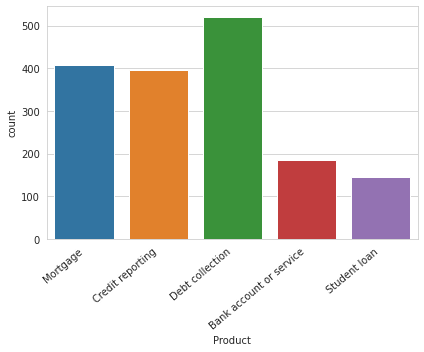

In [124]:
# Plot the data

sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Product', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

**Split the data into training and test sets**

In [125]:
# Split into X/y

complaints = dataset["ConsumerComplaint"].values
labels = dataset[["Product"]].values

X_train, y_train, X_test, y_test = train_test_split(complaints,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(1320,) (1320, 1)
(331,) (331, 1)


**Vectorize a text corpus**

1. **fit_on_texts** Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).
2. **texts_to_sequences** Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.  

Why don't combine them? Because you almost always fit once and convert to sequences many times. You will fit on your training corpus once and use that exact same word_index dictionary at train / eval / testing / prediction time to convert actual text into sequences to feed them to the network. So it makes sense to keep those methods separate

In [126]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
dict(list(word_index.items())[0:10])

Found 5047 unique tokens.


{'<OOV>': 1,
 'account': 2,
 'call': 7,
 'credit': 3,
 'debt': 9,
 'inform': 8,
 'loan': 6,
 'payment': 5,
 'receiv': 10,
 'report': 4}

In [127]:
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

Shape of data tensor: (1320, 200)
Shape of data tensor: (331, 200)


**One Hot Encode the labals**

In [128]:
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

# Check categories
print(encode.categories_)
print(encode.inverse_transform([[0.11397464,0.18473952,0.28436756,0.40149176,0.01542656]]))

print(validation_labels.toarray()[1])

[array(['Bank account or service', 'Credit reporting', 'Debt collection',
       'Mortgage', 'Student loan'], dtype=object)]
[['Mortgage']]
[1. 0. 0. 0. 0.]


In [129]:
# Check the same of the data
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))


(1320, 200)
(331, 5)
(331, 200)
(1320, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [130]:
# The labels must be converted to arrays

# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

**Build the Model**

In [132]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001), 
                               EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1),
                               EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)])

Epoch 1/100
33/33 [==============================] - 4s 111ms/step - loss: 1.5768 - accuracy: 0.2547 - val_loss: 1.4847 - val_accuracy: 0.4053 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 3s 106ms/step - loss: 1.4622 - accuracy: 0.3807 - val_loss: 1.3967 - val_accuracy: 0.4659 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 3s 106ms/step - loss: 1.3571 - accuracy: 0.4820 - val_loss: 1.2712 - val_accuracy: 0.6174 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 4s 106ms/step - loss: 1.2079 - accuracy: 0.5710 - val_loss: 1.1021 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 4s 107ms/step - loss: 1.0908 - accuracy: 0.6449 - val_loss: 0.9476 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 4s 107ms/step - loss: 0.9656 - accuracy: 0.6866 - val_loss: 0.8512 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 3s 106ms/st

**Plot the Model Loss and Accuracy for each epoch**

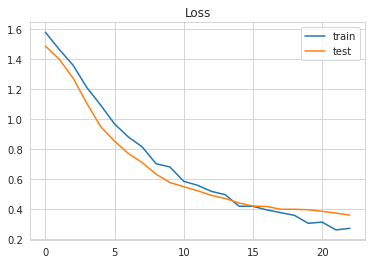

In [133]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

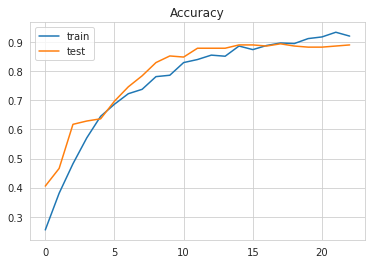

In [134]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

**Evaluating the model and make predictions**

In [0]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [136]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 88.52%
Precision: 0.89
Recall: 0.89
F1 score: 0.89


{'accuracy': 0.89, 'f1': 0.89, 'precision': 0.89, 'recall': 0.89}

In [137]:
# Let's create a Classification report

print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['Product'].unique()))

                         precision    recall  f1-score   support

               Mortgage       0.94      0.74      0.83        39
       Credit reporting       0.92      0.78      0.84        76
        Debt collection       0.82      0.97      0.89        99
Bank account or service       0.90      0.98      0.94        84
           Student loan       0.96      0.82      0.89        33

               accuracy                           0.89       331
              macro avg       0.91      0.86      0.88       331
           weighted avg       0.89      0.89      0.88       331



**And finally a Confusion Matrix**

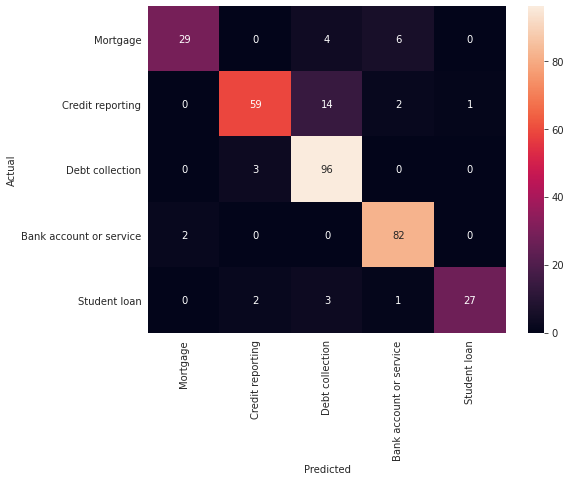

In [140]:
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [141]:
complaint = original_text[18]
new_complaint = [clean_text(complaint)]
print(complaint)
print(new_complaint)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')

My identity was stolen. I filed a complaint, police report, affidavit, etc. I contacted the original company, and the collection agency to resolve this debt. Both of them keep sending me to each other, and neither will help in resolving this issue. I have spoken to supervisors at each company and still get the same answer- contact the other company. I want this debt removed from my credit, as it was fraudulent. The collection agency even offered to settle for {$300.00}! I am not paying a dime to a company I never had an account with!
['ident stolen file complaint polic report affidavit etc contact origin compani collect agenc resolv debt keep send neither help resolv issu spoken supervisor compani still get answer contact compani want debt remov credit fraudul collect agenc even offer settl pay dime compani never account']

Product category id: 2
Predicted label is: ['Debt collection']
Accuracy score: 97.91606068611145
